## Titanic data - GLM model (logistic regression) in caret 
Full dataset from: biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls (edited some column names)  
Feature info: http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt  
Kaggle competition: https://www.kaggle.com/c/titanic    
Note: Titanic sank on April 14, 1912 (April 14 is start of collision, early April 15 sunk UK time)

In [244]:
# we are using caret ...
library(caret)

# download from above, put in a folder and read (this is all titanic data)
titanic <- read.csv('titanicfull.csv') # option: , stringsAsFactors = F (not very useful here)
#length(titanic) # 14 columns
#nrow(titanic) # 1309 rows 
# dim gets both rows and cols
dim(titanic)
head(titanic, 5) # first 5 rows  
# column names 
# colnames(titanic)
str(titanic)

[1] 1309   14

pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,homedest
1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NA,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NA,"Montreal, PQ / Chesterville, ON"
1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"
1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,,135,"Montreal, PQ / Chesterville, ON"
1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"


'data.frame':	1309 obs. of  14 variables:
 $ pclass  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ survived: int  1 1 0 0 0 1 1 0 1 0 ...
 $ name    : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 22 24 25 26 27 31 46 47 51 55 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 1 2 1 2 1 2 1 2 ...
 $ age     : num  29 0.917 2 30 25 ...
 $ sibsp   : int  0 1 1 1 1 0 1 0 2 0 ...
 $ parch   : int  0 2 2 2 2 0 0 0 0 0 ...
 $ ticket  : Factor w/ 929 levels "110152","110413",..: 188 50 50 50 50 125 93 16 77 826 ...
 $ fare    : num  211 152 152 152 152 ...
 $ cabin   : Factor w/ 187 levels "","A10","A11",..: 45 81 81 81 81 151 147 17 63 1 ...
 $ embarked: Factor w/ 4 levels "","C","Q","S": 4 4 4 4 4 4 4 4 4 2 ...
 $ boat    : Factor w/ 28 levels "","1","10","11",..: 13 4 1 1 1 14 3 1 28 1 ...
 $ body    : int  NA NA NA 135 NA NA NA NA NA 22 ...
 $ homedest: Factor w/ 370 levels "","?Havana, Cuba",..: 310 232 232 232 232 238 163 25 23 230 ...


In [245]:
# gets stats and missing values
summary(titanic)

     pclass         survived                                   name     
 Min.   :1.000   Min.   :0.000   Connolly, Miss. Kate            :   2  
 1st Qu.:2.000   1st Qu.:0.000   Kelly, Mr. James                :   2  
 Median :3.000   Median :0.000   Abbing, Mr. Anthony             :   1  
 Mean   :2.295   Mean   :0.382   Abbott, Master. Eugene Joseph   :   1  
 3rd Qu.:3.000   3rd Qu.:1.000   Abbott, Mr. Rossmore Edward     :   1  
 Max.   :3.000   Max.   :1.000   Abbott, Mrs. Stanton (Rosa Hunt):   1  
                                 (Other)                         :1301  
     sex           age              sibsp            parch      
 female:466   Min.   : 0.1667   Min.   :0.0000   Min.   :0.000  
 male  :843   1st Qu.:21.0000   1st Qu.:0.0000   1st Qu.:0.000  
              Median :28.0000   Median :0.0000   Median :0.000  
              Mean   :29.8811   Mean   :0.4989   Mean   :0.385  
              3rd Qu.:39.0000   3rd Qu.:1.0000   3rd Qu.:0.000  
              Max.   :80.0

In [246]:
# missing data: we have 1 missing fare, 263 age, 2 embarked, many cabin and boat. 
# Let's assume others are not important (home dest, boat, ..)

# first, deal with fare - get row with missing fare 
mfare <- titanic[is.na(titanic$fare),]

# calculate mean of similar rows (trying to be more accurate - this is a matter of life and death!)
meanFare <- mean((titanic[(titanic$pclass == 3 & titanic$embarked == 'S'),])$fare, na.rm = T)
meanFare

# calculate mean age for people with parch < 2 and sibsp < 2 (most of those missing age in this range)
meanAge <- mean((titanic[(titanic$parch < 2 & titanic$sibsp < 2),])$age, na.rm = T)
meanAge

[1] 14.43542

[1] 31.33882

In [247]:
# assign mean to the row(s)
titanic$fare[is.na(titanic$fare)] <- meanFare

In [248]:
# identify rows with missing age 
#mage <- titanic[is.na(titanic$age),]
#dim(mage)
# to impute, we can be more detailed and group by sex, sibsp, parch and even title (ex. Dr). This is 
# left as an exercise. We'll just take the mean here (not a great idea)
#titanic$age[is.na(titanic$age)] <- mean(titanic$age, na.rm = T) # mean = 29.88
titanic$age[is.na(titanic$age)] <- meanAge

#### Note: no detailed info available on the life boats feature, but it seems highly correlated to survival. Only a few people whose 'boat' feature is empty survived (23) and fewer ones with non-empty 'boat' feature died (9). So, unless life boats were assigned before disaster, this feature should not be used.

In [249]:
# impute boat and cabin - add two new columns
titanic$boat2 <- ifelse(titanic$boat =='',0, 1)
titanic$cabin2 <- ifelse(titanic$cabin =='',0, 1)
# we'll convrt to factor after finding correlation

In [250]:
# find correlation
num_cols <- sapply(titanic, is.numeric)
titanic_num <- titanic[num_cols]
# impute body or remove it (int, has NA's). Let's drop it 
titanic_num$body <- NULL
titanic_cor <- cor(titanic_num)
findCorrelation(titanic_cor, cutoff = 0.90) # boot2 (feature # 7) has over 90% correlation
head(titanic_num,5)

[1] 7

pclass,survived,age,sibsp,parch,fare,boat2,cabin2
1,1,29.0000,0,0,211.3375,1,1
1,1,0.9167,1,2,151.5500,1,1
1,0,2.0000,1,2,151.5500,0,1
1,0,30.0000,1,2,151.5500,0,1
1,0,25.0000,1,2,151.5500,0,1


### Note: if boat2 is included, over .97 accuracy is reached - highly correlated to survival. It was removed from this model

In [251]:
# now set these to factor (can ignore boat2 as it won't be used)
titanic$boat2 <- factor(titanic$boat2)
titanic$cabin2 <- factor(titanic$cabin2)

In [252]:
# finally, we have 2 missing for emabarked. Since most are from S, we set these as S
titanic[(titanic$embarked == ''),]
titanic$embarked[titanic$embarked == ''] <- 'S'
titanic[(titanic$embarked == ''),]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,homedest,boat2,cabin2
169,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,,6,NA,,1,1
285,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,,6,NA,"Cincinatti, OH",1,1


pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,homedest,boat2,cabin2


In [253]:
# change these to factor? based on description, these sould be numbers
# can keep pclass as ordered category (although reversed in meaning: class 1 is more valuable than class 3)

#titanic$sibsp <- factor(titanic$sibsp)
#titanic$parch <- factor(titanic$parch)

In [254]:
set.seed(4321)
titanic_sampling_vector <- createDataPartition(titanic$survived, p = 0.75, list = FALSE)
titanic_train <- titanic[titanic_sampling_vector,]
titanic_train_labels <- titanic$survived[titanic_sampling_vector]
titanic_test <- titanic[-titanic_sampling_vector,]
titanic_test_labels <- titanic$survived[-titanic_sampling_vector]
dim(titanic_train)
dim(titanic_test)

[1] 982  16

[1] 327  16

In [255]:
# define glm model: ignore  - name - ticket  - boat2 - body - homedest 
# we are not using cross validation for simplicity
titanic_glm <- glm(survived ~ pclass + sex + age + fare + parch + sibsp + embarked + cabin2  , 
                   data = titanic_train, family = binomial("logit"))
summary(titanic_glm)


Call:
glm(formula = survived ~ pclass + sex + age + fare + parch + 
    sibsp + embarked + cabin2, family = binomial("logit"), data = titanic_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4700  -0.6199  -0.4318   0.6305   2.4644  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.6549754  0.5919683   7.864 3.73e-15 ***
pclass      -0.8084071  0.1579277  -5.119 3.07e-07 ***
sexmale     -2.6198465  0.1869679 -14.012  < 2e-16 ***
age         -0.0406998  0.0075479  -5.392 6.96e-08 ***
fare         0.0006016  0.0021136   0.285  0.77592    
parch       -0.0419751  0.0998995  -0.420  0.67436    
sibsp       -0.2411905  0.1043393  -2.312  0.02080 *  
embarkedQ   -0.6614609  0.3458636  -1.912  0.05581 .  
embarkedS   -0.6647668  0.2196220  -3.027  0.00247 ** 
cabin21      0.6014154  0.2786675   2.158  0.03091 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken 

In [256]:
# assess the train model
train_predictions <- predict(titanic_glm, newdata = titanic_train, type = "response")
train_class_predictions <- as.numeric(train_predictions > 0.5)
mean(train_class_predictions == titanic_train$survived)

[1] 0.7912424

In [257]:
test_predictions <- predict(titanic_glm, newdata = titanic_test, type = "response")
test_class_predictions <- as.numeric(test_predictions > 0.5)
mean(test_class_predictions == titanic_test$survived)

[1] 0.7889908

In [258]:
confusionMatrix(data = test_class_predictions, reference = titanic_test$survived, 
                mode = "prec_recall", positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 174  38
         1  31  84
                                         
               Accuracy : 0.789          
                 95% CI : (0.7407, 0.832)
    No Information Rate : 0.6269         
    P-Value [Acc > NIR] : 1.987e-10      
                                         
                  Kappa : 0.5436         
 Mcnemar's Test P-Value : 0.4701         
                                         
              Precision : 0.7304         
                 Recall : 0.6885         
                     F1 : 0.7089         
             Prevalence : 0.3731         
         Detection Rate : 0.2569         
   Detection Prevalence : 0.3517         
      Balanced Accuracy : 0.7687         
                                         
       'Positive' Class : 1              
                                         

[1] 0.8329068

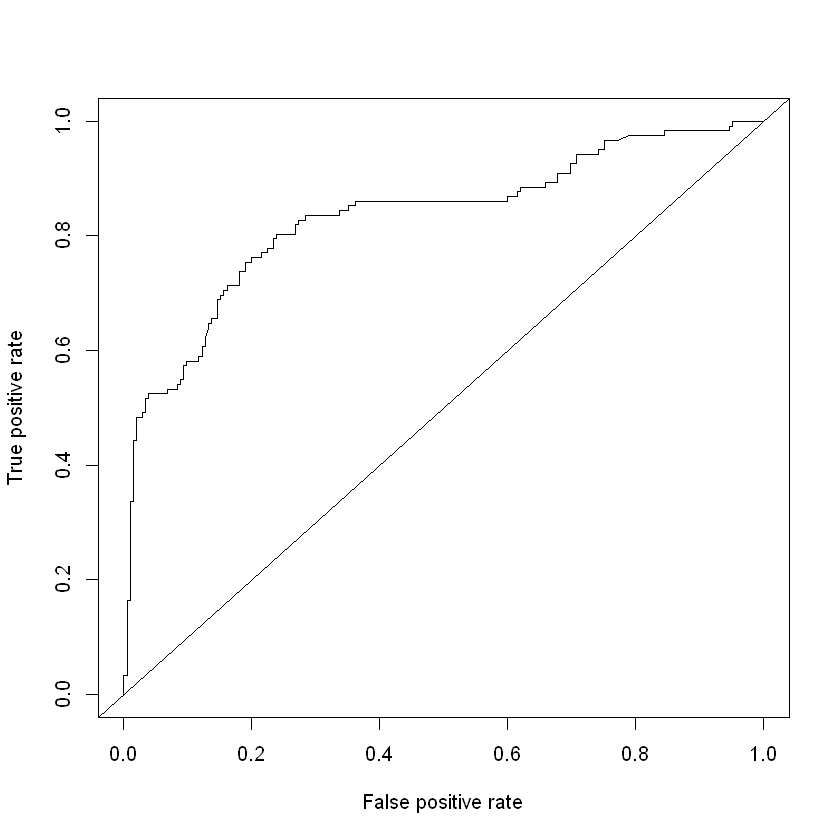

In [259]:
# Compute AUC for predicting Class with the model 
# see https://www.r-bloggers.com/evaluating-logistic-regression-models/
library(ROCR)
prob <- predict(titanic_glm, newdata=titanic_test, type="response")
pred <- prediction(prob, titanic_test$survived)
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

# see how good our work is
plot(perf)
abline(0, 1) #add a 45 degree line

auc <- performance(pred, measure = "auc") 
#auc
auc <- auc@y.values[[1]]
auc

         Observed
Predicted FALSE TRUE
    FALSE   174   38
    TRUE     31   84

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   174   31
     TRUE     38   84
                                         
               Accuracy : 0.789          
                 95% CI : (0.7407, 0.832)
    No Information Rate : 0.6483         
    P-Value [Acc > NIR] : 2.105e-08      
                                         
                  Kappa : 0.5436         
 Mcnemar's Test P-Value : 0.4701         
                                         
            Sensitivity : 0.7304         
            Specificity : 0.8208         
         Pos Pred Value : 0.6885         
         Neg Pred Value : 0.8488         
             Prevalence : 0.3517         
         Detection Rate : 0.2569         
   Detection Prevalence : 0.3731         
      Balanced Accuracy : 0.7756         
                                         
       'Positive' Class : TRUE           
                                         

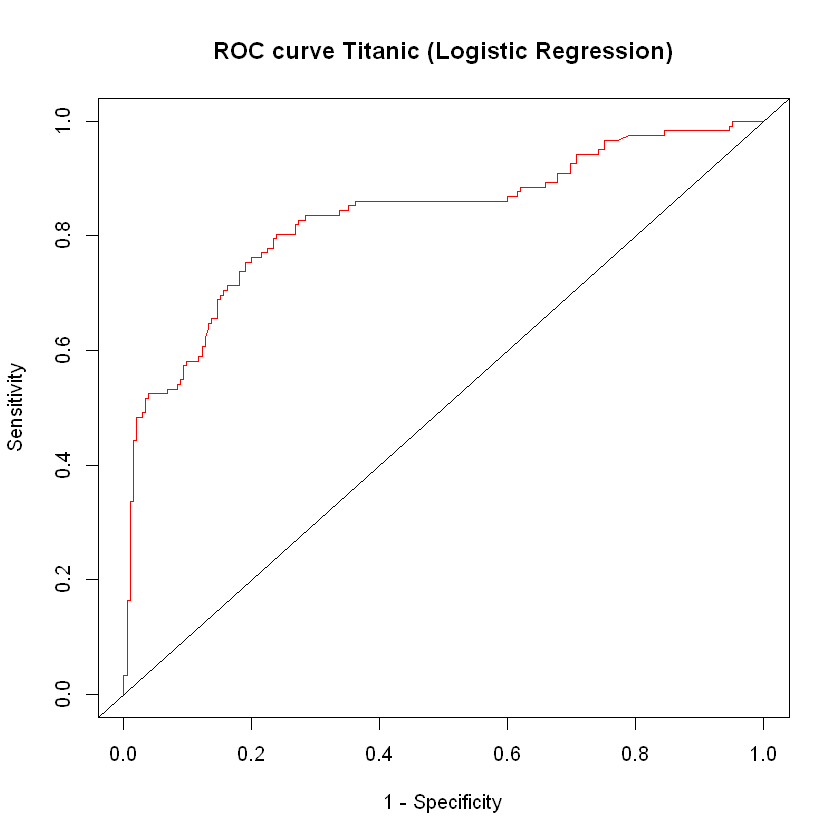

In [260]:
# ---- http://shahramabyari.com/2016/02/22/measuring-performance-of-classifiers/ -----
# sensitivity = TP rate or recall (+ves ratio correctly identified)
# specificity = TN rate (-ves ratio correctly identified)

#Predict the test data and calculate confusion matrix
predictions <- ifelse(predict(titanic_glm, titanic_test, type='response') > 0.5, TRUE, FALSE)
confusion  <- table(predictions, as.logical(titanic_test$survived),dnn = c('Predicted','Observed'))
confusion
plot(perf, col=rainbow(7), main="ROC curve Titanic (Logistic Regression)", 
     xlab="1 - Specificity", ylab="Sensitivity") 
abline(0, 1)
# confusion matrix outputs sensitivity and specificity but label should be classes (used as.logical)
confusionMatrix(as.logical(titanic_test$survived), predictions, positive = "TRUE")

#### training and testing performances are close. Good enough. Now your turn to tune parameters and try the Kaggle challenge (train and test already split). The two next cells are extra.

In [261]:
# Explore the target
table(titanic$survived)
prop.table(table(titanic$survived))


  0   1 
809 500 


       0        1 
0.618029 0.381971 

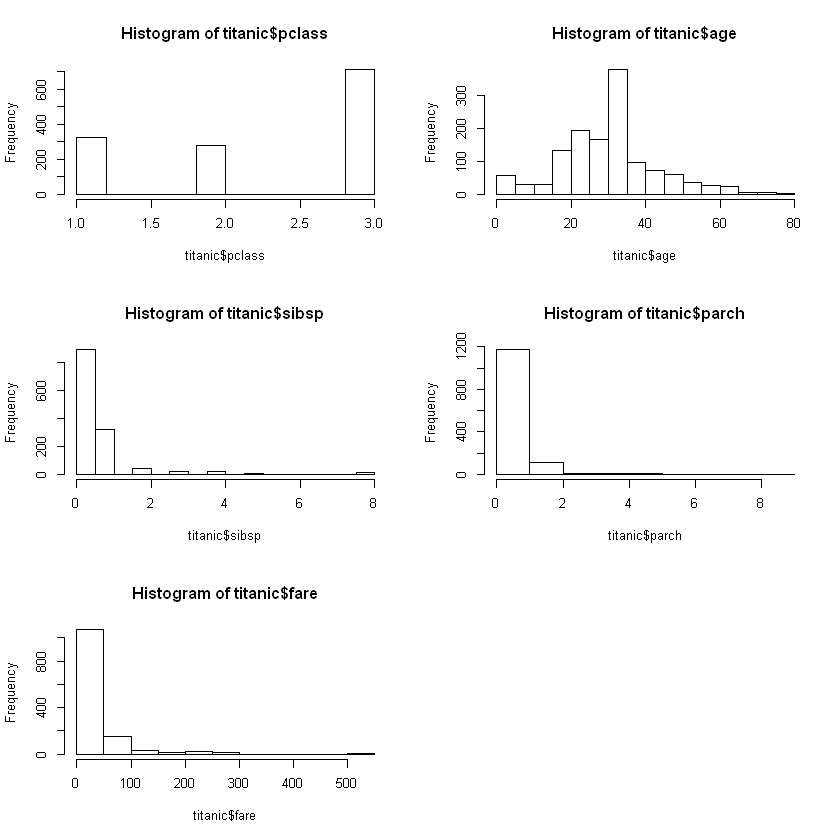

In [262]:
par(mfrow=c(3,2))
hist(titanic$pclass)
hist(titanic$age)
# set these to numeric
#titanic$sibsp <- as.numeric(titanic$sibsp)
hist(titanic$sibsp)
hist(titanic$parch)
hist(titanic$fare)